In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [5]:
from sklearn.metrics import confusion_matrix

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
data = pd.read_csv('economic_times_sentiment.csv')
data.shape

(2508, 2)

In [9]:
data["sentiment"]=data["sentiment"].map({'Positive':2,'Neutral':1,'Negative':0})

In [10]:
data.head()

,headline,sentiment
0,Amazon's founder Jeff Bezos to step down as CE...,1
1,WhatsApp Pay was possible because of India's U...,0
2,FB-Jio will help digital platforms value creat...,2
3,Microsoft allows employees to work from home p...,1
4,"Instagram turns 10, launches new well-being fe...",1


In [11]:
model = 'bert-base-cased'

In [12]:
tokenizer = BertTokenizer.from_pretrained(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

*Спецтокены и токенизация текста*

In [13]:
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [14]:
token_lens = []

for txt in data.headline:
    tokens = tokenizer.encode(txt, max_length=100,truncation=True )
    token_lens.append(len(tokens))

*Определение длины токенов*

<ipython-input-15-8406bdc0edea>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

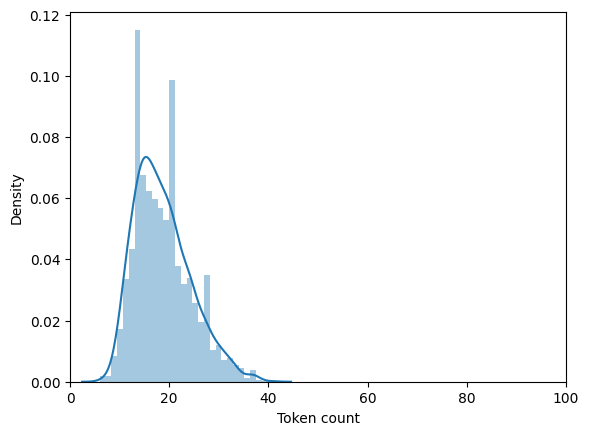

In [15]:
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count')

In [16]:
max_len = 50

*Подготовка Torch датасета*

In [17]:
class GPHeadlineDataset(Dataset):

    def __init__(self, headlines, targets, tokenizer, max_len):
        self.headlines = headlines
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.headlines)


    def __getitem__(self, item):
        headline = str(self.headlines[item])
        target = self.targets[item]


        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

*Разделение на тренировочную и тестовую выборку*

In [18]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)


In [19]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    ds = GPHeadlineDataset(
        headlines=data.headline.to_numpy(),
        targets=data.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [20]:
ds = GPHeadlineDataset(
        headlines=data_train.headline.to_numpy(),
        targets=data_train.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

In [21]:
batch_size=128

In [22]:
train_data_loader = create_data_loader(data_train, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(data_test, tokenizer, max_len, batch_size)

In [23]:
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['headline_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


*Загрузка модели *

In [24]:
bert_model = BertModel.from_pretrained(model)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [25]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )['pooler_output']


        output = self.drop(pooled_output)
        return self.out(output)

In [26]:
class_names = ['negative', 'neutral', 'positive']

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

*Тренировка*

In [29]:
epochs=10

In [30]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for i in data_loader:
        input_ids = i["input_ids"].to(device)
        attention_mask = i["attention_mask"].to(device)
        targets = i["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())


        loss.backward()


        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

*Оценка модели*

In [32]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for i in data_loader:
            input_ids = i["input_ids"].to(device)
            attention_mask = i["attention_mask"].to(device)
            targets = i["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

*Обучение модели*

In [33]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(epochs):

    print(f"Epoch {epoch + 1}/{epochs}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(data_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)


    torch.save(model.state_dict(), 'best_model_state.bin')

Epoch 1/10
----------
Train loss 0.9670118801295757 accuracy 0.5134596211365902
Epoch 2/10
----------
Train loss 0.616197170689702 accuracy 0.7472582253240279
Epoch 3/10
----------
Train loss 0.2778609157539904 accuracy 0.9032901296111664
Epoch 4/10
----------
Train loss 0.12943799630738795 accuracy 0.9591226321036889
Epoch 5/10
----------
Train loss 0.06540563242742792 accuracy 0.9805583250249251
Epoch 6/10
----------
Train loss 0.060381592134945095 accuracy 0.9825523429710866
Epoch 7/10
----------
Train loss 0.018295487127033994 accuracy 0.9955134596211365
Epoch 8/10
----------
Train loss 0.012537856833660044 accuracy 0.9955134596211365
Epoch 9/10
----------
Train loss 0.00822624358261237 accuracy 0.9985044865403788
Epoch 10/10
----------
Train loss 0.005469046329380944 accuracy 0.9990029910269191


In [34]:
def get_predictions(model, data_loader):
    model = model.eval()

    headline_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for i in data_loader:
            texts = i["headline_text"]
            input_ids = i["input_ids"].to(device)
            attention_mask = i["attention_mask"].to(device)
            targets = i["targets"].to(device)


            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            headline_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return headline_texts, predictions, prediction_probs, real_values

In [35]:
y_headline_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.68      0.71        77
     neutral       0.84      0.84      0.84       249
    positive       0.80      0.84      0.82       176

    accuracy                           0.81       502
   macro avg       0.79      0.78      0.79       502
weighted avg       0.81      0.81      0.81       502



In [37]:
cm_ = confusion_matrix(y_test, y_pred)

In [38]:
cm_

array([[ 52,  16,   9],
       [ 13, 208,  28],
       [  5,  23, 148]])

**Предсказание на собственных данных**

In [39]:
data_AI = pd.read_csv('AI_data_headers.csv')

In [43]:
data_AI

,headline
0,MIT-Takeda Program wraps up with 16 publicatio...
1,Researchers leverage shadows to model 3D scene...
2,Understanding the visual knowledge of language...
3,A smarter way to streamline drug discovery
4,Technique improves the reasoning capabilities ...
...,...
1774,Uber will know if you're drunk before you even...
1775,IBM computer taps AI to successfully debate hu...
1776,Gen. Anthony Tata: One more reason to beware o...
1777,Researchers create a video game Mario that thi...


In [40]:
data_AI['headline']

0       MIT-Takeda Program wraps up with 16 publicatio...
1       Researchers leverage shadows to model 3D scene...
2       Understanding the visual knowledge of language...
3              A smarter way to streamline drug discovery
4       Technique improves the reasoning capabilities ...
                              ...                        
1774    Uber will know if you're drunk before you even...
1775    IBM computer taps AI to successfully debate hu...
1776    Gen. Anthony Tata: One more reason to beware o...
1777    Researchers create a video game Mario that thi...
1778    Marc Thiessen: Shame on Google for treating th...
Name: headline, Length: 1779, dtype: object

In [46]:
from tqdm import tqdm
predicted_labels = []
for headline in tqdm(data_AI['headline']):
  encoded_review = tokenizer.encode_plus(
      headline,
      max_length=max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  predicted_labels.append(prediction.cpu()[0].numpy())
data_AI['predicted_label'] = predicted_labels

100%|██████████| 1779/1779 [00:25<00:00, 69.76it/s]


In [51]:
data_AI

,headline,predicted_label
0,MIT-Takeda Program wraps up with 16 publicatio...,1
1,Researchers leverage shadows to model 3D scene...,1
2,Understanding the visual knowledge of language...,1
3,A smarter way to streamline drug discovery,2
4,Technique improves the reasoning capabilities ...,2
...,...,...
1774,Uber will know if you're drunk before you even...,1
1775,IBM computer taps AI to successfully debate hu...,1
1776,Gen. Anthony Tata: One more reason to beware o...,0
1777,Researchers create a video game Mario that thi...,1
